In [1]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# -----------------------------
# 1) 데이터 준비
# -----------------------------
df = pd.read_csv("/content/drive/MyDrive/ml-programming-lab/week5/diabetes.csv")

# X, y 분리 (Outcome, BMI 제거 → X / BMI → y)
X = df.drop(columns=["Outcome", "BMI"]).values.astype("float32")
y = df["BMI"].values.astype("float32")

# 학습/테스트 분리 (random_state 제거하고 싶으면 해당 인자만 지워도 됨)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=24
)

# 스케일링(필수 권장): train으로 fit → test에 transform만
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

In [3]:
# -----------------------------
# 2) 모델 구성(MLP)
# -----------------------------
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.15),
    layers.Dense(64, activation="relu"),
    layers.Dense(1)  # 회귀는 선형 출력
])

model.compile(
    optimizer="adam",
    loss="mse",                        # 회귀 손실
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse"), "mae"]
)

In [4]:
# -----------------------------
# 3) 학습
# -----------------------------
es = EarlyStopping(
    monitor="val_loss", patience=20, restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=300,
    batch_size=32,
    callbacks=[es],
    verbose=0
)

In [5]:
# -----------------------------
# 4) 평가
# -----------------------------
pred = model.predict(X_test, verbose=0).ravel()

mse  = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, pred)
r2   = r2_score(y_test, pred)

print("=== Deep Learning (MLP) - BMI Regression ===")
print(f"Test MSE : {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")
print(f"Test R^2 : {r2:.4f}")

# 예측 샘플 5개
for i in range(5):
    print(f"[{i}] y_true={y_test[i]:.2f} | y_pred={pred[i]:.2f}")

=== Deep Learning (MLP) - BMI Regression ===
Test MSE : 59.9697
Test RMSE: 7.7440
Test MAE : 5.2638
Test R^2 : 0.1894
[0] y_true=29.50 | y_pred=22.43
[1] y_true=49.70 | y_pred=45.43
[2] y_true=27.40 | y_pred=31.89
[3] y_true=23.90 | y_pred=25.97
[4] y_true=42.80 | y_pred=48.36


=== Correlation with BMI ===
BMI                         1.000000
SkinThickness               0.392573
Outcome                     0.292695
BloodPressure               0.281805
Glucose                     0.221071
Insulin                     0.197859
DiabetesPedigreeFunction    0.140647
Age                         0.036242
Pregnancies                 0.017683
Name: BMI, dtype: float64


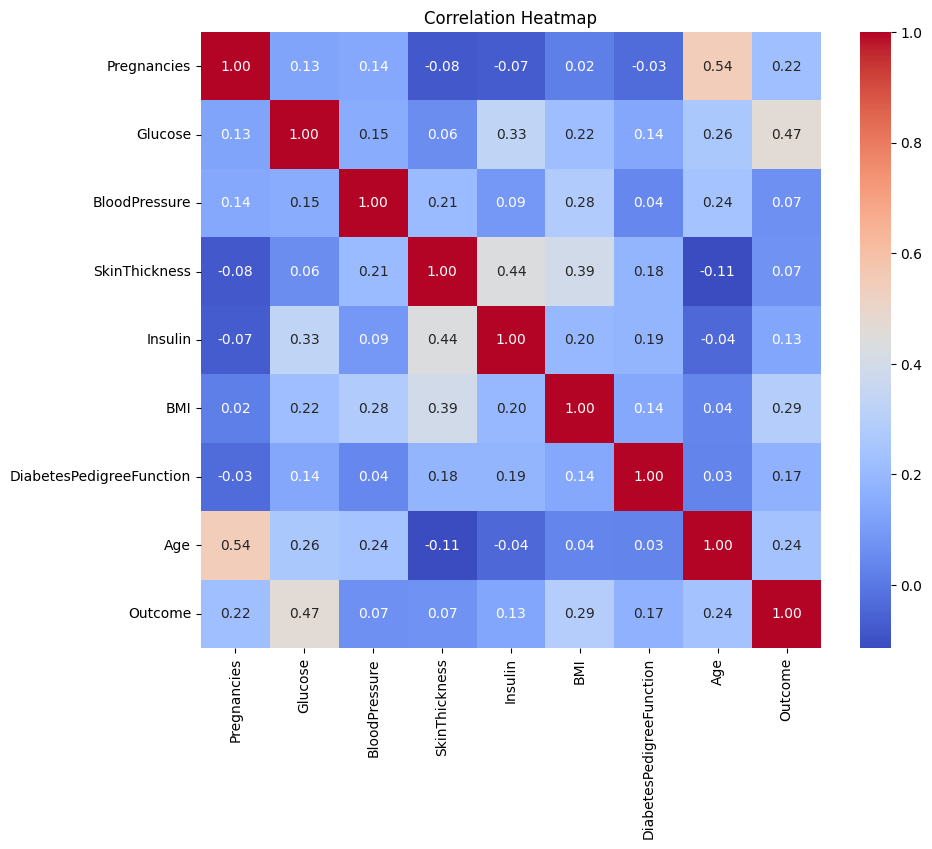

In [6]:
# -----------------------------
# 5) 상관관계 분석
# -----------------------------
corr = df.corr(numeric_only=True)

print("=== Correlation with BMI ===")
print(corr["BMI"].sort_values(ascending=False))

# 히트맵 시각화
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()